In [12]:
import pandas as pd
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.trend import CCIIndicator
from ta.trend import ADXIndicator
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("data/PastData_FullFloorHSX.csv")
codeList = pd.read_csv("data/BankHOSECodeList.csv")
# codeList = ['ACB']

In [9]:
# df = df.loc[df['code'].isin(codeList)]
df = df.loc[df['code'].isin(codeList['Mã'])]

In [4]:
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [97]:
df.to_csv("data/done_data.csv", index=False)

In [108]:
df = pd.read_csv("data/done_data.csv")

In [10]:
df

,Unnamed: 0,code,date,open,high,low,close,nmVolume
174,174,TCB,2019-01-02,26.00,26.05,25.60,25.60,1329030.0
184,184,STB,2019-01-02,12.00,12.05,11.60,11.60,3858970.0
190,190,EIB,2019-01-02,14.00,14.10,14.00,14.00,276290.0
213,213,VPB,2019-01-02,19.95,19.95,19.40,19.40,1037420.0
216,216,BID,2019-01-02,34.40,34.40,33.45,33.50,805700.0
...,...,...,...,...,...,...,...,...
488532,488532,HDB,2023-12-29,19.40,20.30,19.15,20.30,12437600.0
488541,488541,STB,2023-12-29,27.65,28.10,27.60,27.95,16014900.0
488556,488556,VCB,2023-12-29,83.50,83.90,80.30,80.30,1621700.0
488585,488585,VIB,2023-12-29,19.70,19.90,19.60,19.60,8957600.0


<Axes: >

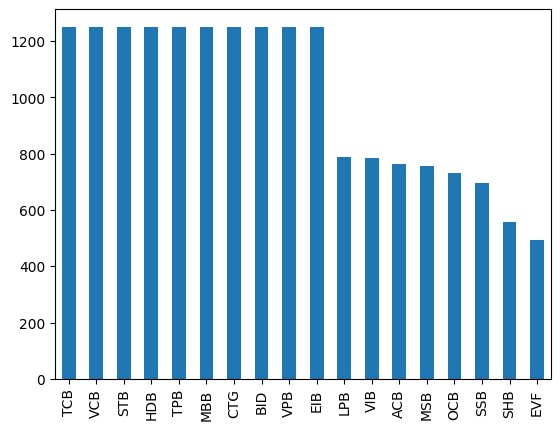

In [16]:
df['code'].value_counts().plot(kind='bar')

In [110]:
def add_technical_indicators(df):
    # Calculate MACD and MACD Signal
    df.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)

    # Calculate RSI
    df['rsi'] = ta.rsi(df['close'])

    # Calculate CCI
    df['cci'] = ta.cci(df['high'], df['low'], df['close'])

    df['adx'] = ta.adx(df['high'], df['low'], df['close'])

    return df

In [113]:
df = add_tech_indicators(df)

In [114]:
df

,code,date,open,high,low,close,nmVolume,macd,rsi,cci,adx
0,ACB,2020-12-09,28.10,28.95,27.80,28.55,24200930.0,0.000000,NaN,NaN,NaN
1,ACB,2020-12-10,28.80,28.80,27.90,27.95,9233750.0,-0.013462,0.000000,-66.666667,NaN
2,ACB,2020-12-11,28.10,28.25,27.80,28.20,4459820.0,-0.009400,30.120482,-85.294118,100.000000
3,ACB,2020-12-14,28.30,28.50,28.10,28.20,7325960.0,-0.007323,30.120482,11.111111,44.230769
4,ACB,2020-12-15,28.20,28.25,27.90,28.00,7305490.0,-0.013998,23.945651,-93.023256,9.676080
...,...,...,...,...,...,...,...,...,...,...,...
760,ACB,2023-12-25,23.25,23.45,23.20,23.35,7582400.0,0.256018,58.438971,143.475126,15.788812
761,ACB,2023-12-26,23.40,23.40,23.25,23.25,5728800.0,0.265149,57.344514,125.362739,15.788812
762,ACB,2023-12-27,23.20,23.40,23.20,23.30,4866000.0,0.273270,57.753753,124.159139,14.447992
763,ACB,2023-12-28,23.30,23.95,23.30,23.75,10513000.0,0.312415,61.217926,178.287405,24.408727


In [115]:
df.to_csv("data/done_data_indicators.csv", index=False)

: 

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   code           765 non-null    object 
 1   date           765 non-null    object 
 2   open           765 non-null    float64
 3   high           765 non-null    float64
 4   low            765 non-null    float64
 5   close          765 non-null    float64
 6   nmVolume       765 non-null    float64
 7   macd           765 non-null    object 
 8   macd_signal    765 non-null    object 
 9   rsi            751 non-null    float64
 10  cci            752 non-null    float64
 11  MACD_12_26_9   740 non-null    float64
 12  MACDh_12_26_9  732 non-null    float64
 13  MACDs_12_26_9  732 non-null    float64
dtypes: float64(10), object(4)
memory usage: 83.8+ KB


In [37]:
temp = df['MACD'].dropna
temp

<bound method Series.dropna of 184110         NaN
184498         NaN
184888         NaN
185276         NaN
185665         NaN
            ...   
487010    0.256018
487134    0.265149
487692    0.273270
488152    0.312415
488206    0.351490
Name: MACD, Length: 765, dtype: float64>

In [33]:
df.describe()

,open,high,low,close,nmVolume,MACD,MACD_Signal,MACD_Histogram,RSI,CCI,ADX
count,765.000000,765.000000,765.000000,765.000000,7.650000e+02,740.000000,732.000000,732.000000,752.000000,746.000000,765.000000
mean,27.851046,28.177647,27.511503,27.842484,6.309958e+06,-0.056649,-0.060310,0.000053,49.544736,4.750796,20.765849
std,5.378581,5.463588,5.295227,5.393013,4.548956e+06,0.568210,0.522073,0.204499,11.656455,110.057265,9.216719
min,17.900000,18.700000,17.450000,17.500000,7.281000e+05,-1.860577,-1.679260,-1.080578,9.608934,-628.318584,0.000000
25%,22.850000,23.050000,22.600000,22.850000,3.272800e+06,-0.342951,-0.326592,-0.091658,41.844622,-80.053707,14.887920
50%,25.200000,25.550000,25.000000,25.300000,5.156300e+06,-0.015046,-0.023660,0.011299,49.476645,3.024883,19.473471
75%,33.000000,33.300000,32.650000,33.000000,8.094700e+06,0.208384,0.193744,0.107279,57.051319,87.295445,25.062323
max,46.300000,46.300000,45.000000,45.900000,3.515600e+07,2.508760,1.953767,0.805535,89.858418,316.169828,55.755149


In [11]:
df[df['code'] == 'ACB']

,code,date,open,high,low,close,nmVolume,macd,rsi,cci,adx
0,ACB,2020-12-09,28.10,28.95,27.80,28.55,24200930.0,NaN,NaN,NaN,NaN
1,ACB,2020-12-10,28.80,28.80,27.90,27.95,9233750.0,NaN,NaN,NaN,NaN
2,ACB,2020-12-11,28.10,28.25,27.80,28.20,4459820.0,NaN,NaN,NaN,NaN
3,ACB,2020-12-14,28.30,28.50,28.10,28.20,7325960.0,NaN,NaN,NaN,NaN
4,ACB,2020-12-15,28.20,28.25,27.90,28.00,7305490.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
760,ACB,2023-12-25,23.25,23.45,23.20,23.35,7582400.0,NaN,NaN,NaN,NaN
761,ACB,2023-12-26,23.40,23.40,23.25,23.25,5728800.0,NaN,NaN,NaN,NaN
762,ACB,2023-12-27,23.20,23.40,23.20,23.30,4866000.0,NaN,NaN,NaN,NaN
763,ACB,2023-12-28,23.30,23.95,23.30,23.75,10513000.0,NaN,NaN,NaN,NaN


In [4]:
np.prod([3, 101, 101])

30603

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
import torch
torch.cuda.is_available()

True